In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from itertools import product
import heapq

## **Data**

In [34]:
# Read the CSV file into a DataFrame
file_address = 'data/ibex.csv'
# file_address = 'data/dji.csv'
# file_address = 'data/gdaxi.csv'

index_name = file_address.split('/')[-1].split('.')[0].upper()

df = pd.read_csv(file_address)

# Convert the 'date' column to datetime if it's not already in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

# Drop 'Volume' and 'Adj Close' columns
df = df.drop(['Volume', 'Adj Close'], axis=1)

In [35]:
df

,Open,High,Low,Close
Date,,,,
2011-01-03,9899.400391,9993.599609,9850.500000,9888.299805
2011-01-04,9895.500000,9974.200195,9799.400391,9888.400391
2011-01-05,9877.500000,9882.400391,9599.299805,9801.400391
2011-01-06,9803.200195,9832.599609,9678.400391,9702.700195
2011-01-07,9682.400391,9699.400391,9497.799805,9560.700195
...,...,...,...,...
2019-12-23,9650.200195,9670.900391,9639.000000,9659.599609
2019-12-24,9632.099609,9661.799805,9607.799805,9661.799805
2019-12-27,9673.000000,9700.500000,9657.500000,9700.500000


In [36]:
# Define the split date
split_date = pd.to_datetime('2019-01-01')

# Split the data into train and test sets
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

In [37]:
def split_data_x(df, time_window):
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index: index + time_window].reshape(-1))

    out = np.array(data)
    
    return out

In [38]:
def split_data_y(df, time_window):
    df = df['Close']
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index + time_window])

    out = np.array(data)
    out = np.expand_dims(out, axis=1)

    return out

# **Strategies**

In [39]:
def calculate_profit_factor(strategy):
    positive_trades = strategy.loc[strategy > 0].sum()
    negative_trades = strategy.loc[strategy < 0].sum()
    profit_factor = abs(positive_trades / negative_trades)
    return profit_factor

In [40]:
def calculate_metrics(df):
    # Calculate number of trades
    num_trades = df['Trades'].sum()
    
    # Calculate net profit of the trades
    net_profit = df['PriceStrategy'].sum()
    
    # Calculate profit factor
    profit_factor = calculate_profit_factor(df['Strategy'])
    
    # Calculate average net of each trade
    avg_net_trade = net_profit / num_trades
    
    # Calculate maximum drawdown (price)
    max_drawdown = (df['CPriceStrategy'] - df['CPriceStrategy'].cummax()).min()
    
    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Number of Trades': [num_trades],
        'Net Profit': [net_profit],
        'Profit Factor': [profit_factor],
        'Average Net per Trade': [avg_net_trade],
        'Maximum Drawdown': [max_drawdown],
    }, index=['Strategy'])
    
    return metrics_df

## **TEMA**

In [41]:
def ema(df, period):
    return df.ewm(span = period, min_periods = period).mean() 

In [42]:
def df_change(df, symbol):
    temp = pd.DataFrame(df['Close'])
    temp = temp.rename({'Close': symbol}, axis=1)
    return temp

In [43]:
def tema_strategy(df, symbol, short_period, mid_period, long_period):
    df = df_change(df, symbol)
    temp = df.copy()
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['Position'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [44]:
def optimize_tema_parameters(df, symbol, short_range, mid_range, long_range):
    top_combinations = []
    
    for short_period, mid_period, long_period in product(short_range, mid_range, long_range):
        if short_period < mid_period < long_period:
            result = tema_strategy(df, symbol, short_period, mid_period, long_period)
            c_strategy = result['CStrategy'].iloc[-1]
            
            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
    
    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]
    
    return best_combinations, best_c_strategy

In [45]:
# Define the parameter ranges
# short_range = range(2, 25)
# mid_range = range(5, 41)
# long_range = range(8, 81)

# test
short_range = range(2, 5)
mid_range = range(5, 7)
long_range = range(8, 12)

# Run the optimization
best_combinations, best_c_strategy = optimize_tema_parameters(train_data, index_name, short_range, mid_range, long_range)
best_tema_params = best_combinations[0]

# Print the results
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (2, 5, 8)
Combination 2: (2, 6, 8)
Combination 3: (2, 5, 9)
Combination 4: (2, 6, 9)
Combination 5: (3, 6, 8)
Best CStrategy: [0.9723223629466213, 0.9476243764850367, 0.9244638122291597, 0.900981482100017, 0.859010805614707]


In [46]:
for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination
    
    # Run the strategy with the current combination
    strategy_result = tema_strategy(test_data, index_name, short_period, mid_period, long_period)
    
    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])
    
    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Combination 1: (2, 5, 8)
Profit Factor: 0.8619537068500254

Combination 2: (2, 6, 8)
Profit Factor: 0.8542822785796289

Combination 3: (2, 5, 9)
Profit Factor: 0.8686855276572873

Combination 4: (2, 6, 9)
Profit Factor: 0.8606066926290155

Combination 5: (3, 6, 8)
Profit Factor: 0.7961800496632466



In [47]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,59.0,-915.801758,0.861954,-15.522064,-1515.402344


## **MACD**

In [48]:
def macd_strategy(df, symbol, short_period, long_period, signal_period):
    df = df_change(df, symbol)
    temp = df.copy()
    
    # Calculate MACD line
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Generate trading signals
    temp['Position'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [49]:
def optimize_macd_parameters(df, symbol, short_range, long_range, signal_range):
    top_combinations = []
    
    for short_period, long_period, signal_period in product(short_range, long_range, signal_range):
        if short_period < long_period:# and short_period < signal_period and long_period < signal_period:
            result = macd_strategy(df, symbol, short_period, long_period, signal_period)
            c_strategy = result['CStrategy'].iloc[-1]
            
            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
    
    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]
    
    return best_combinations, best_c_strategy

In [50]:
# Define the parameter ranges
# short_range = range(2, 10)
# long_range = range(5, 35)
# signal_range = range(5, 20)

# test
short_range = range(2, 5)
long_range = range(5, 7)
signal_range = range(5, 10)

# Run the optimization
best_combinations, best_c_strategy = optimize_macd_parameters(train_data, index_name, short_range, long_range, signal_range)
best_macd_params = best_combinations[0]

# Print the best combinations and CStrategy values
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (2, 6, 6)
Combination 2: (2, 5, 7)
Combination 3: (3, 5, 5)
Combination 4: (2, 5, 8)
Combination 5: (2, 6, 7)
Best CStrategy: [2.0826343248835086, 2.07414619396561, 1.8325203448908154, 1.547947186325397, 1.4387398803626734]


In [51]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,60.0,495.306641,1.072903,8.255111,-772.899414


# **Prediction**

## **Linear Regression**

In [52]:
time_window = 6

In [53]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data, time_window)
y_train = split_data_y(train_data, time_window)
x_test = split_data_x(test_data, time_window)
y_test = split_data_y(test_data, time_window)

In [54]:
# printing shape of x and y data
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2038, 24)
y_train.shape =  (2038, 1)
x_test.shape =  (249, 24)
y_test.shape =  (249, 1)


In [55]:
# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression()

In [56]:
# Make predictions on the test set
y_pred = regression_model.predict(x_test)

In [57]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 2000)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 1000
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 53.18727437487757
Root Mean Squared Error (RMSE): 69.73528694013477
Symmetric Mean Absolute Percentage Error (sMAPE): 5.806619616407719
Mean Absolute Percentage Error (MAPE): 5.807646609927657


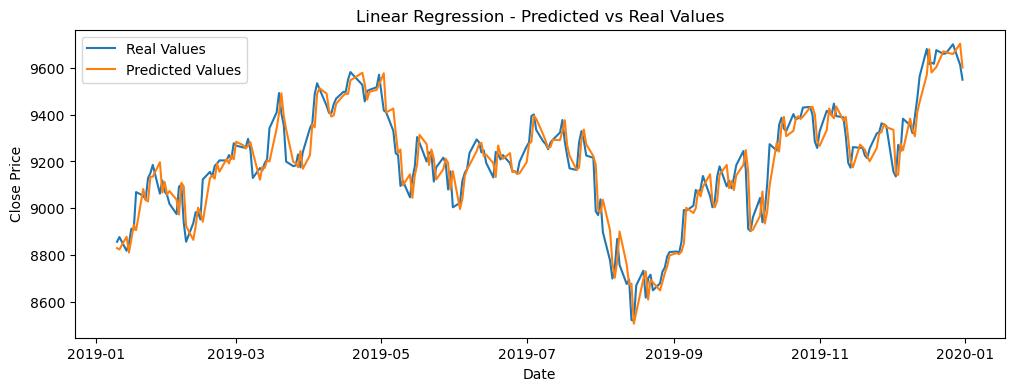

In [58]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression - Predicted vs Real Values')
plt.legend()
plt.show()

In [64]:
y_pred_lr = pd.DataFrame(y_pred)

# Rename the column
y_pred_lr = y_pred_lr.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_lr = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_lr],
                      ignore_index=True)
y_pred_lr

,Predicted
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
250,9671.058798
251,9666.421813
252,9658.894083
253,9703.020904


## **ANN**

In [65]:
# Define the neural network architecture
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x[:, -1] # Output only the last column (close price)

In [66]:
# Preprocess the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[['Open', 'Close', 'High', 'Low']])
test_data_scaled = scaler.fit_transform(test_data[['Open', 'Close', 'High', 'Low']])

# Create a new DataFrame with scaled values and original column names
train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Open', 'Close', 'High', 'Low'])
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Open', 'Close', 'High', 'Low'])

In [67]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data_scaled, time_window)
y_train = split_data_y(train_data_scaled, time_window)
x_test = split_data_x(test_data_scaled, time_window)
y_test = split_data_y(test_data, time_window)

In [68]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [69]:
# Set the hyperparameters
#16, 0.00001, 5000

hidden_size = 16
lr = 0.00001
num_iterations = 5000

In [70]:
# Define the model
input_size = x_train.shape[1]
output_size = 1
model = ANN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [71]:
# Train the model
for iteration in range(num_iterations):
    # Forward pass
    output = model(x_train)
    loss = criterion(output, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss
    if (iteration + 1) % 500 == 0:
        print(f'Iteration: {iteration + 1}, Loss: {loss.item()}')

/Users/hamidrezarahimzadeh/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2038, 1])) that is different to the input size (torch.Size([2038])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 500, Loss: 0.15365199744701385
Iteration: 1000, Loss: 0.09474914520978928
Iteration: 1500, Loss: 0.06763450056314468
Iteration: 2000, Loss: 0.06181071326136589
Iteration: 2500, Loss: 0.06070584058761597
Iteration: 3000, Loss: 0.05991499125957489
Iteration: 3500, Loss: 0.05901924893260002
Iteration: 4000, Loss: 0.058002013713121414
Iteration: 4500, Loss: 0.0568702295422554
Iteration: 5000, Loss: 0.05563460290431976


In [72]:
# Compute predictions on the test data
y_pred = model(x_test)

# Reshape the y_pred array to match the shape of the original data
y_pred = y_pred.detach().numpy().reshape(-1, 1)

temp = scaler.fit_transform(test_data[['Close']])

y_pred = scaler.inverse_transform(y_pred)   

y_test = y_test.detach().numpy()

In [73]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 2000)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 1000
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 112.142944
Root Mean Squared Error (RMSE): 140.28694
Symmetric Mean Absolute Percentage Error (sMAPE): 12.214904
Mean Absolute Percentage Error (MAPE): 12.198120355606079


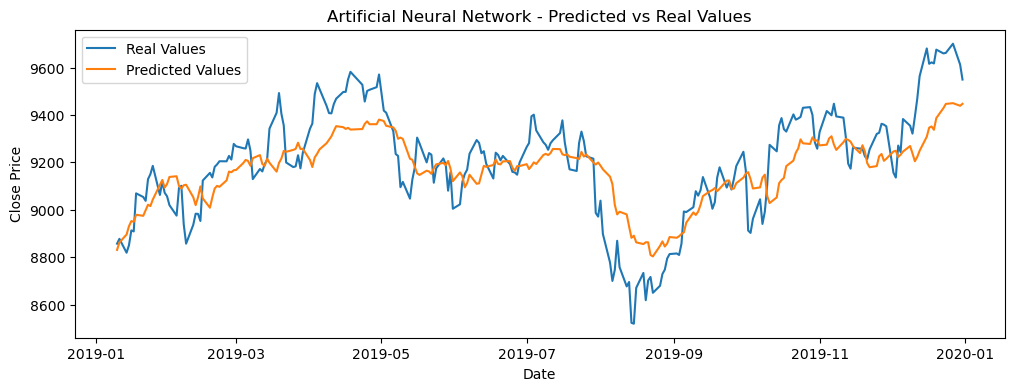

In [74]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Artificial Neural Network - Predicted vs Real Values')
plt.legend()
plt.show()

In [75]:
y_pred_ann = pd.DataFrame(y_pred)

# Rename the column
y_pred_ann = y_pred_ann.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_ann = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_ann],
                      ignore_index=True)
y_pred_ann

,Predicted
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
250,9428.970703
251,9446.519531
252,9449.696289
253,9438.639648


# **Hybrid Strategies**

## **hTEMA**

In [94]:
def htema_strategy(df, symbol, short_period, mid_period, long_period, y_pred):
    df = df_change(df, symbol)
    temp = df.copy()
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['PredictedPrice'] = y_pred['Predicted']
    
    temp['Position'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [95]:
y_pred_lr

,Predicted
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
250,9671.058798
251,9666.421813
252,9658.894083
253,9703.020904


In [96]:
htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr)

,IBEX,ShortEMA,MidEMA,LongEMA,PredictedPrice,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,8550.000000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,8523.299805,8529.974854,NaN,NaN,NaN,0,-0.003128,-0.000000,-26.700195,-0.000000,0.0,0.996877,1.000000,-26.700195,0.000000
2019-01-04,8737.799805,8673.853666,NaN,NaN,NaN,0,0.024855,0.000000,214.500000,0.000000,0.0,1.021965,1.000000,187.799805,0.000000
2019-01-07,8776.299805,8743.004810,NaN,NaN,NaN,0,0.004396,0.000000,38.500000,0.000000,0.0,1.026468,1.000000,226.299805,0.000000
2019-01-08,8847.299805,8812.822120,8751.049583,NaN,NaN,0,0.008057,0.000000,71.000000,0.000000,0.0,1.034772,1.000000,297.299805,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,9659.599609,9658.567121,9632.179934,9593.365905,NaN,1,-0.001645,-0.001645,-15.900391,-15.900391,0.0,1.129778,0.908978,1109.599609,-868.801758
2019-12-24,9661.799805,9660.722243,9642.053224,9608.573438,NaN,1,0.000228,0.000228,2.200195,2.200195,0.0,1.130035,0.909185,1111.799805,-866.601562
2019-12-27,9700.500000,9687.240748,9661.535483,9629.001563,NaN,1,0.003997,0.003997,38.700195,38.700195,0.0,1.134561,0.912827,1150.500000,-827.901367
